# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

from sklearn import tree
from sklearn.metrics import accuracy_score, f1_score, precision_score, make_scorer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder

## Ignore
---

In [2]:
# Calculating the weighted Gini index across a multi-node split for multiple classes
split = pd.DataFrame({
    'Family': [1,3],
    'Sports': [8,0],
    'Luxury': [1,7],
})
def Gini(split: pd.DataFrame):

    node_records = split.apply(np.sum,axis=0)
    total_recrods = node_records.sum()
    
    gini = 0
    for c in split.columns:
        gini += (node_records[c]/total_recrods) * (1 - ((split[c]/node_records[c])**2).sum())
    
    return gini.__round__(3)

node_records = split.apply(np.sum,axis=0)
ni_div_n = node_records/node_records.sum()
-((ni_div_n)*(np.log2(ni_div_n))).sum()
# Gini(split)/(-((ni_div_n)*(np.log2(ni_div_n))).sum())

np.float64(1.5219280948873621)

---

In [3]:
# fetch dataset 
waveform_database_generator_version_1 = fetch_ucirepo(id=107) 
statlog_german_credit_data = fetch_ucirepo(id=144)

In [4]:
# extracting features and tragets for both datasets
german_data_X = statlog_german_credit_data.data.features
german_data_Y = statlog_german_credit_data.data.targets

waveform_data_X = waveform_database_generator_version_1.data.features
waveform_data_Y = waveform_database_generator_version_1.data.targets

In [5]:
# converting string values to numeric using label encoding
non_numeric = german_data_X.select_dtypes(include='object').columns
label_encoder = LabelEncoder()
german_data_X.loc[:,non_numeric] = german_data_X[non_numeric].apply(label_encoder.fit_transform)

# Part 1
---

Building a decision tree model for two datasets and evaluating the model using **holdout** and **cross validation** methods

- Holdout Method

,accuracy,precision,f1-measure
trials,,,
1,0.73,0.732632,0.731242
2,0.68,0.665405,0.670209
3,0.67,0.679647,0.674244
4,0.65,0.694669,0.667774
5,0.66,0.684667,0.668264


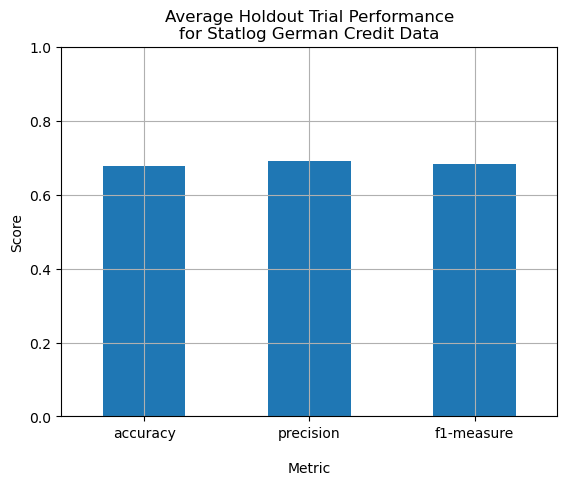

In [154]:
def holdout(X, Y, trials, percent_train, shuffle, dataset_title="", criterion="gini"):
    
    accuracies = []
    precisions = []
    f1_measures = []

    for t in range(trials):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=percent_train, shuffle=shuffle)
    
        clf = tree.DecisionTreeClassifier(criterion=criterion)
        clf.fit(X_train,Y_train)
        Y_pred = clf.predict(X_test)
    
        accuracies.append(accuracy_score(Y_test, Y_pred))
        precisions.append(precision_score(Y_test, Y_pred, average='weighted'))
        f1_measures.append(f1_score(Y_test, Y_pred, average='weighted'))

    clf_trials = pd.DataFrame({
                    'accuracy': accuracies,
                    'precision': precisions,
                    'f1-measure': f1_measures,
                    }, index=np.arange(start=1, stop=trials+1))
    clf_trials.index.name = 'trials'

    display(clf_trials)

    clf_trials.mean().plot(kind='bar', ylim=[0,1], ylabel='Score', title=f'Average Holdout Trial Performance\nfor {dataset_title}')
    plt.xticks(rotation=0)
    plt.xlabel('Metric', labelpad=15)
    plt.grid(True)
    plt.show()
    return clf_trials

german_holdout_results_gini = holdout(german_data_X, german_data_Y, trials=5, percent_train=0.9, shuffle=True, dataset_title="Statlog German Credit Data")
    

,accuracy,precision,f1-measure
trials,,,
1,0.65,0.676923,0.660503
2,0.69,0.693405,0.691635
3,0.71,0.702964,0.704630
4,0.79,0.809595,0.797739
5,0.70,0.689189,0.693452


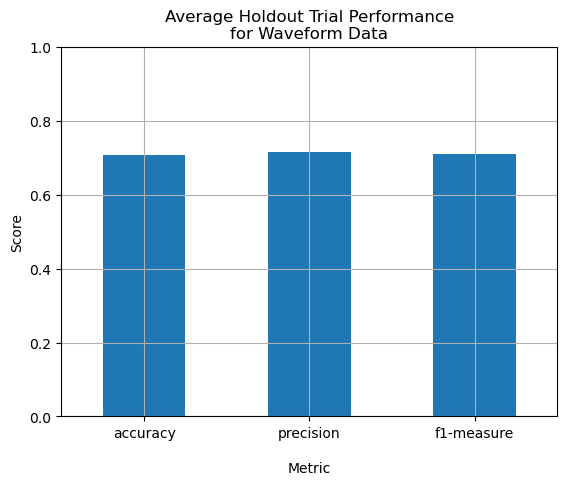

In [155]:
waveform_holdout_results_gini = holdout(german_data_X, german_data_Y, trials=5, percent_train=0.9, shuffle=True, dataset_title="Waveform Data")

- 10-fold cross validation

,accuracy,precision,f1-measure
trials,,,
1,0.68,0.714167,0.690549
2,0.69,0.692987,0.691426
3,0.68,0.656876,0.664033
4,0.70,0.694444,0.696940
5,0.64,0.626195,0.632143
6,0.69,0.681431,0.685094
7,0.74,0.750980,0.744301
8,0.73,0.722831,0.725727
9,0.72,0.738021,0.726459


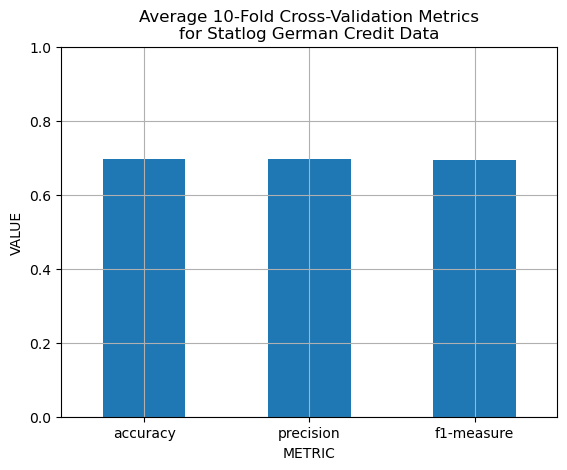

In [156]:
# german data
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
    }
clf = tree.DecisionTreeClassifier(criterion='entropy')

def cross_validation(X, Y, scoring, model, dataset_title="", folds=10):

    cv_results = pd.DataFrame(cross_validate(model, X, Y, scoring=scoring, cv=folds), index=np.arange(1,folds+1)).iloc[:,2:]
    cv_results.columns = ['accuracy', 'precision', 'f1-measure']
    cv_results.index.name = 'trials'
    display(cv_results)
    cv_results.mean().plot(kind='bar', ylim=[0,1], xlabel='METRIC', ylabel='VALUE', title=f'Average 10-Fold Cross-Validation Metrics\nfor {dataset_title}')
    plt.xticks(rotation=0)
    plt.grid(True)
    plt.show()
    return cv_results

german_cross_results_gini = cross_validation(german_data_X, german_data_Y, scoring, clf, dataset_title="Statlog German Credit Data")


,accuracy,precision,f1-measure
trials,,,
1,0.784,0.783923,0.783844
2,0.732,0.733152,0.732262
3,0.758,0.757837,0.757831
4,0.760,0.760032,0.759961
5,0.764,0.763858,0.763425
6,0.734,0.736421,0.734613
7,0.752,0.753019,0.752371
8,0.748,0.747508,0.746926
9,0.766,0.766414,0.765484


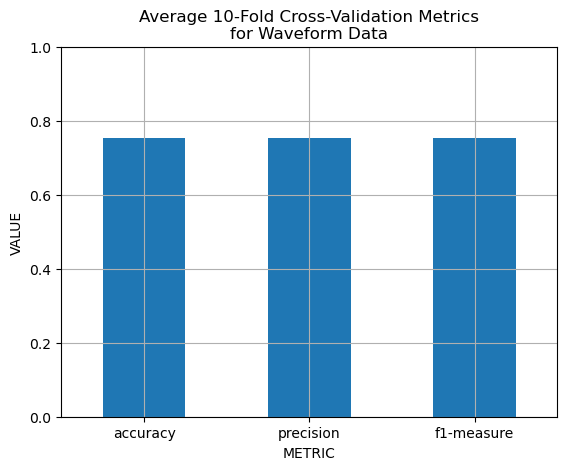

In [157]:
# waveform data
waveform_cross_results_gini = cross_validation(waveform_data_X, waveform_data_Y, scoring, clf, dataset_title="Waveform Data")

# Part 2
---
1. Selecting Entropy as the impurity measure and repeating Part 1

- holdout

,accuracy,precision,f1-measure
trials,,,
1,0.69,0.708566,0.697639
2,0.61,0.623123,0.613610
3,0.81,0.813623,0.811720
4,0.72,0.726286,0.722856
5,0.67,0.653333,0.660046


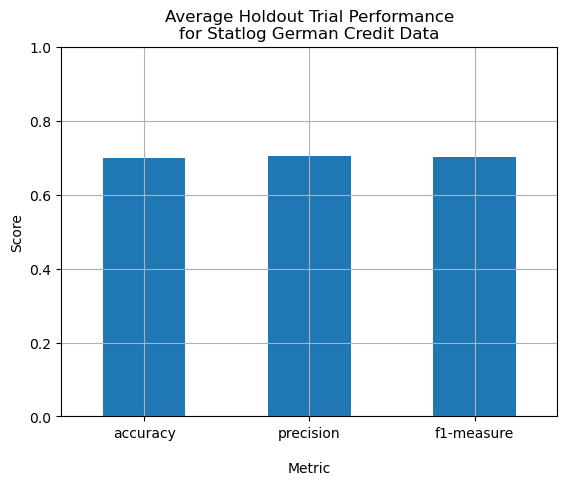

In [158]:
german_holdout_resutls_entropy = holdout(german_data_X, german_data_Y, trials=5, percent_train=0.9, shuffle=True, dataset_title="Statlog German Credit Data", criterion='entropy')

,accuracy,precision,f1-measure
trials,,,
1,0.738,0.738585,0.737847
2,0.770,0.770066,0.770028
3,0.720,0.719940,0.719686
4,0.754,0.754325,0.754026
5,0.804,0.808241,0.803244


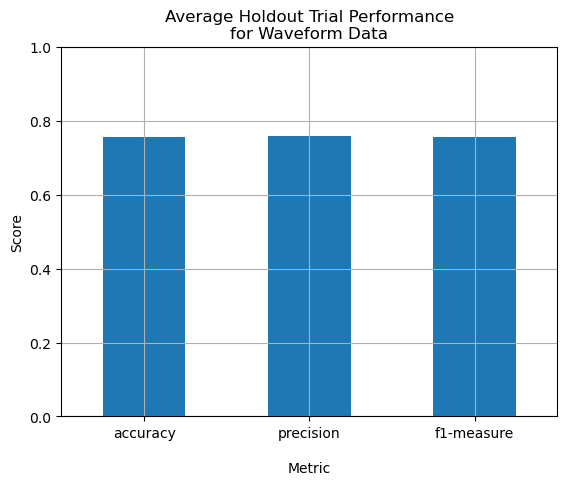

In [159]:
waveform_holdout_resutls_entropy = holdout(waveform_data_X, waveform_data_Y, trials=5, percent_train=0.9, shuffle=True, dataset_title="Waveform Data", criterion='entropy')

- 10-fold cross validation

,accuracy,precision,f1-measure
trials,,,
1,0.69,0.712613,0.698036
2,0.69,0.692987,0.691426
3,0.73,0.718667,0.722382
4,0.69,0.681431,0.685094
5,0.64,0.626195,0.632143
6,0.66,0.660000,0.660000
7,0.69,0.705714,0.696182
8,0.74,0.735317,0.737348
9,0.65,0.653343,0.651610


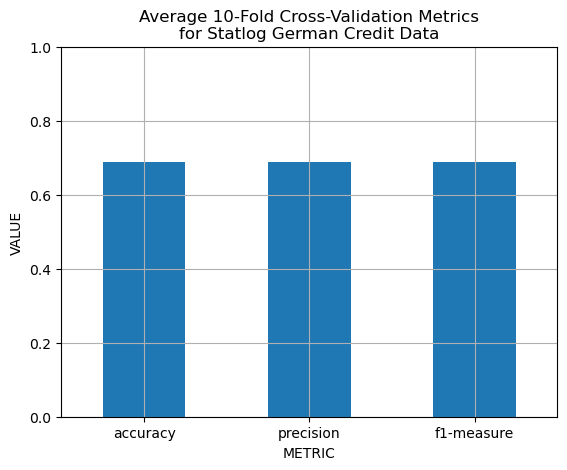

In [160]:
clf = tree.DecisionTreeClassifier(criterion='entropy')

german_cross_results_entropy = cross_validation(german_data_X, german_data_Y,
                                                scoring=scoring, model=clf, dataset_title="Statlog German Credit Data")

,accuracy,precision,f1-measure
trials,,,
1,0.790,0.790560,0.790146
2,0.732,0.732102,0.732047
3,0.764,0.763448,0.763261
4,0.762,0.762490,0.762001
5,0.776,0.775895,0.775523
6,0.718,0.719718,0.718406
7,0.756,0.758010,0.756373
8,0.756,0.755492,0.755288
9,0.752,0.752889,0.751909


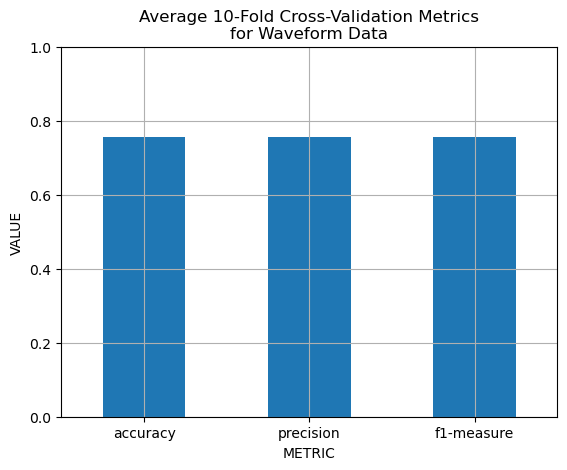

In [161]:
waveform_cross_results_entropy = cross_validation(waveform_data_X, waveform_data_Y,
                                                scoring=scoring, model=clf, dataset_title="Waveform Data")

In [162]:
display(german_cross_results_gini.columns)
display(german_cross_results_entropy.columns)
display(waveform_cross_results_gini.columns)
display(waveform_cross_results_entropy.columns)

Index(['accuracy', 'precision', 'f1-measure'], dtype='object')

Index(['accuracy', 'precision', 'f1-measure'], dtype='object')

Index(['accuracy', 'precision', 'f1-measure'], dtype='object')

Index(['accuracy', 'precision', 'f1-measure'], dtype='object')

,Statlog German Credit Data,Waveform Data
gini,0.697,0.7546
entropy,0.689,0.7558


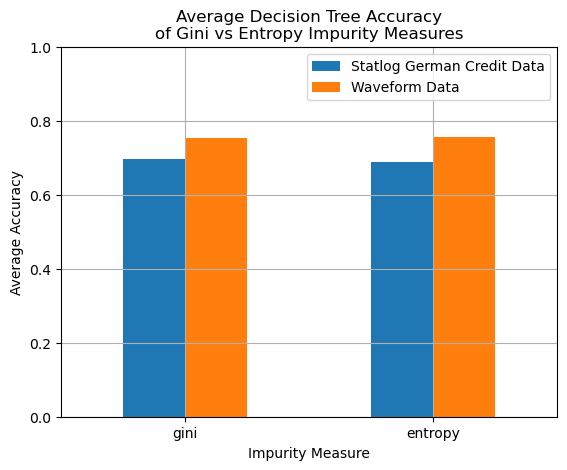

In [163]:
results = pd.DataFrame({
    "Statlog German Credit Data": [german_cross_results_gini['accuracy'].mean(),german_cross_results_entropy['accuracy'].mean()],
    "Waveform Data": [waveform_cross_results_gini['accuracy'].mean(), waveform_cross_results_entropy['accuracy'].mean()]
}, index=['gini', 'entropy'])

display(results)
results.plot(kind='bar', xlabel='Impurity Measure', ylabel='Average Accuracy', ylim=[0,1], title="Average Decision Tree Accuracy\nof Gini vs Entropy Impurity Measures")
plt.grid(True)
plt.xticks(rotation=0)
plt.show()

# Part 3
---
- Using **holdout** method with (train: 90% data set, test: 10% set), investigate the effect of tree depth on the accuracy of the model

    1. Change the tree depth (e.g, 2, 5, 8, ..., 50) and draw training and test accuracy

    2. Explain your observation 

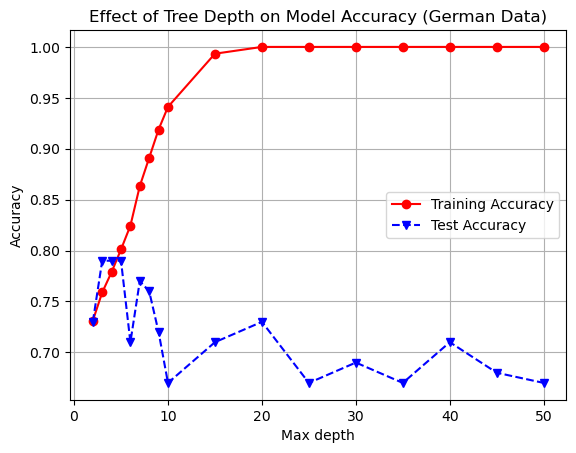

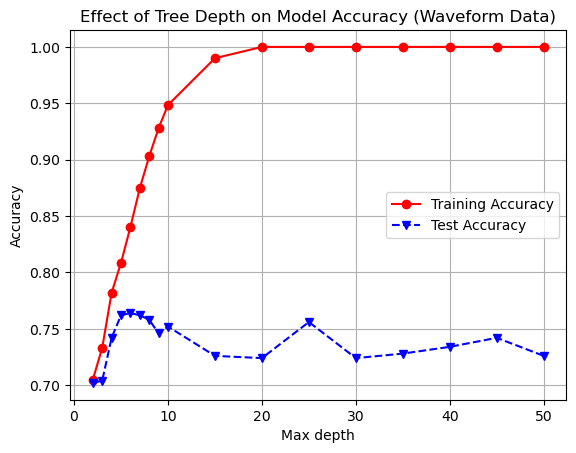

In [166]:
#########################################
# Training and Test set creation
#########################################

# Create a 90-10 training-test split for waveform and german datasets
w_X_train, w_X_test, w_Y_train, w_Y_test = train_test_split(waveform_data_X, waveform_data_Y, test_size=0.1, shuffle=True)
g_X_train, g_X_test, g_Y_train, g_Y_test = train_test_split(german_data_X, german_data_Y, test_size=0.1, shuffle=True)

#########################################
# Model fitting and evaluation
#########################################

maxdepths = [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]

# germain data
g_trainAcc = np.zeros(len(maxdepths))
g_testAcc = np.zeros(len(maxdepths))
# germain data
w_trainAcc = np.zeros(len(maxdepths))
w_testAcc = np.zeros(len(maxdepths))

index = 0
for depth in maxdepths:
    # German data
    g_clf = tree.DecisionTreeClassifier(max_depth=depth)
    g_clf.fit(g_X_train, g_Y_train)
    g_Y_predTrain = g_clf.predict(g_X_train)
    g_Y_predTest = g_clf.predict(g_X_test)
    g_trainAcc[index] = accuracy_score(g_Y_train, g_Y_predTrain)
    g_testAcc[index] = accuracy_score(g_Y_test, g_Y_predTest)
    
    # Waveform data
    w_clf = tree.DecisionTreeClassifier(max_depth=depth)
    w_clf.fit(w_X_train, w_Y_train)
    w_Y_predTrain = w_clf.predict(w_X_train)
    w_Y_predTest = w_clf.predict(w_X_test)
    w_trainAcc[index] = accuracy_score(w_Y_train, w_Y_predTrain)
    w_testAcc[index] = accuracy_score(w_Y_test, w_Y_predTest)
    
    index += 1
    
#########################################
# Plot of training and test accuracies
#########################################
    
# Plot for German data
plt.plot(maxdepths, g_trainAcc, 'ro-', maxdepths, g_testAcc, 'bv--')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.title('Effect of Tree Depth on Model Accuracy (German Data)')
plt.grid(True)
plt.show()

# Plot for Waveform data
plt.plot(maxdepths, w_trainAcc, 'ro-', maxdepths, w_testAcc, 'bv--')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.title('Effect of Tree Depth on Model Accuracy (Waveform Data)')
plt.grid(True)
plt.show()